Project 4 Submission


*   Student name: Jenny Kreiger
*   Student pace: full time
*   Scheduled project review date/time: 
*   Instructor name: Victor Geislinger
*   Blog post URL:

# Introduction

## Business case

Throughout the western United States, there are large tracts of land that have seen little direct human intervention, at least since the US government claimed these areas. These lands contain a wealth of ecological information and natural resources, but it can be challenging to use or preserve these resources without detailed knowledge about what is there and how it may be evolvng as local and global climates change. 

To access this data directly can be prohibitively difficult and expensive. Field surveys require time and personnel, and remote sensing can generate huge amounts of data that must be processed and stored.

An alternative is to use machine learning to try to infer ecological information from data that we already have. In 1999, J. A. Blackard and D. J. Dean published an article in _Computers and Electronics in Agriculture_ demonstrating how two machine learning techniques (an artificial neural network and discriminant analysis) could be used to predict the type of tree cover on a 30 by 30 meter tract of land using only existing cartographic data such as elevation, horizontal distance to water, and soil type. Using over half a million observations with 53 features, Blackard and Dean were able to predict tree cover type with 70.58% accuracy using their artificial neural network. 

Twenty years after Blackard and Dean's study, computational efficiency has improved substantially. This project aims to match or exceed Blackard and Dean's accuracy using a Random Forest classifier, ensemble methods (XGBoost), Support Vector Machines, or a combination of these algorithms. 

The value of this analysis is that ecological features that would be difficult to measure directly can be predicted from existing data, and these predictions can later be validated with selective use of richer data (e.g., satellite imaging)--or the historic results can be compared to what we observe in the present and future.

J. A. Blackard and D. J. Dean, "Comparative accuracies of artificial neural networks and discriminant analysis in predicting forest cover types from cartographic variables," _Computers and Electronics in Agriculture_ 24 (1999), 131-51. (DOI: 10.1016/S0168-1699(99)00046-0)


## Custom functions

Below are several functions I created to help with repetitive tasks.

In [1]:
# Define a function to print selected model metrics
def print_metrics(y_true, y_pred):
    '''Prints accuracy score, confusion matrix, and classification report given
       arrays of ground-truth values and model predictions.'''
    acc_score = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred)
    print('Accuracy:', acc_score)
    print('-------')
    print('Confusion matrix:')
    print(conf_matrix)
    print('-------')
    print('Classification report:')
    print(class_report)


In [2]:
# Define a function to visualize feature importances
def plot_feature_importances(model, x):
    '''Displays a bar chart representing a model's feature importances.'''
    n_features = x.shape[1]
    plt.figure(figsize=(8,10))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), range(1, n_features+1)) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature (Component)")
    plt.title('Feature Importances')

In [3]:
# Define a function to calculate AUC and plot ROC curve
def roc_it(y_test, y_score):
    '''Displays ROC curve given ground-truth data and model scores.'''
    fpr, tpr, thresholds = roc_curve(y_test, y_score)

    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10,8))

    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show();

    print('AUC: {}'.format(auc(fpr, tpr)))

## Load and clean data

In [22]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

The original dataset is about 75MB. <span style='background-color:red'>To save on memory, At the end of this cleaning process I save the cleaned data to new CSV files so that they can be imported direclty without needing to rerun this part of the notebook every time.</span>

First, we read in the original dataset, which can be found at http://kdd.ics.uci.edu/databases/covertype/. A description of the dataset, including a data dictionary, is here: http://kdd.ics.uci.edu/databases/covertype/covertype.data.html.

Below I show two ways to get the data. The first is specific to me; when I'm running the notebook in Google Colab, I mount my Google Drive and access the copy of my data that lives there. The second is more generic; it assumes you have a copy of the dataset in the same folder as the Jupyter Notebook. If you're running this notebook on your own machine, you may want to download a copy of the dataset and use the second method.

In [1]:
# Import method 1: in Colab, mount Drive and then use Pandas
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Import method 1 cont'd: read in the data
df = pd.read_table("/content/drive/My Drive/fs-project-4/covtype.data", sep=',', header=None)
df.head()

In [6]:
# Import method 2: read in the data (stored locally)
df = pd.read_table("covtype.data", sep=',', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


The data comes without column names, so in the next few cells, I generate and insert those.

In [7]:
# Generate column names for the 40 soil type columns
soil_types = []
for n in range(1, 41):
    str_n = str(n)
    name = 'Soil_Type_' + str_n
    soil_types.append(name)
    
print(soil_types)

['Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39', 'Soil_Type_40']


In [8]:
# Name the columns
colnames = ['Elevation', 'Aspect', 'Slope', 'Hor_Dist_Hyd', 'Ver_Dist_Hyd',
            'Hor_Dist_Road', 'Hillshade_9am', 'Hillshade_noon', 'Hillshade_3pm',
            'Hor_Dist_Fire', 'WA_1', 'WA_2', 'WA_3', 'WA_4', 'Soil_Type_1', 
            'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 
            'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 
            'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 
            'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 
            'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 
            'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 
            'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 
            'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 
            'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36', 'Soil_Type_37', 
            'Soil_Type_38', 'Soil_Type_39', 'Soil_Type_40', 'Cover_Type',]
df.columns = colnames
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
Elevation         581012 non-null int64
Aspect            581012 non-null int64
Slope             581012 non-null int64
Hor_Dist_Hyd      581012 non-null int64
Ver_Dist_Hyd      581012 non-null int64
Hor_Dist_Road     581012 non-null int64
Hillshade_9am     581012 non-null int64
Hillshade_noon    581012 non-null int64
Hillshade_3pm     581012 non-null int64
Hor_Dist_Fire     581012 non-null int64
WA_1              581012 non-null int64
WA_2              581012 non-null int64
WA_3              581012 non-null int64
WA_4              581012 non-null int64
Soil_Type_1       581012 non-null int64
Soil_Type_2       581012 non-null int64
Soil_Type_3       581012 non-null int64
Soil_Type_4       581012 non-null int64
Soil_Type_5       581012 non-null int64
Soil_Type_6       581012 non-null int64
Soil_Type_7       581012 non-null int64
Soil_Type_8       581012 non-null int64
Soil_Type

Every observation in this dataset represents a 30 by 30-meter tract of land in one of four forest preserves in Colorado. The first 9 columns describe features of each land tract that are pretty self-explanatory (see the data dictionary referenced above). The columns named 'WA_#' binary columns representing which of the four areas the observation pertains to. These are followed by 40 binary columns recording what type of soil is present in the tract. Last is 'Cover_Type,' which records which of 7 tree types was predominant in the tract.

## EDA

At this early stage, I am concerned about class imbalance, i.e., that there may be lots of one type of tree cover and few examples of another. This imbalance could cause my machine learning algorithm to find shortcuts to maximizing whatever performance metric we're using, for instance by simply never predicting a rare class.

In [9]:
# Check class balance
df.Cover_Type.value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Cover_Type, dtype: int64

As I feared, the classes are very imbalanced: the smallest one is just 1% the size of the largest one! I will address this problem in the section on preprocessing below.

Let's take a look at the continuous variables and see whether they are normally distributed, since non-normal distributions can negatively impact our predictive power.

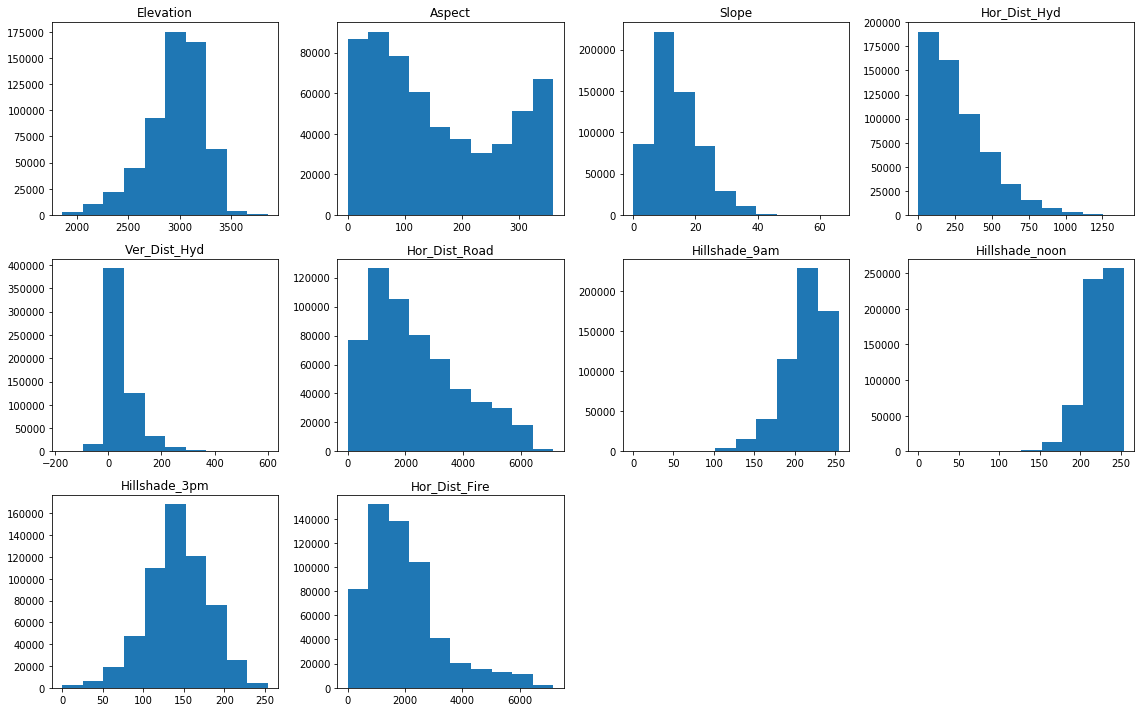

In [10]:
# Visualize distributions of continuous variables
to_hist = ['Elevation', 'Aspect', 'Slope', 'Hor_Dist_Hyd', 'Ver_Dist_Hyd',
           'Hor_Dist_Road', 'Hillshade_9am', 'Hillshade_noon', 'Hillshade_3pm',
           'Hor_Dist_Fire']

plt.figure(figsize=(16,10))
for idx, col in enumerate(to_hist):
    plt.subplot(3, 4, idx+1)
    plt.hist(df[col])
    plt.title(col)
plt.tight_layout();


Some of the continuous variables are skewed right or left, and `Aspect` appears to be bimodal. 

I'm also curious to see whether any of the variables are correlated with one another (and therefore could be eliminated). For instance, there might be a soil type that only occurs in one of the forest preserves. A correlation matrix and heatmap can help us detect this, but it's not a big worry. Principal Components Analysis (below) will help us avoid any repercussions of multicollinearity.

In [11]:
# View correlation matrix
df.corr()

,Elevation,Aspect,Slope,Hor_Dist_Hyd,Ver_Dist_Hyd,Hor_Dist_Road,Hillshade_9am,Hillshade_noon,Hillshade_3pm,Hor_Dist_Fire,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
Elevation,1.000000,0.015735,-0.242697,0.306229,0.093306,0.365559,0.112179,0.205887,0.059148,0.148022,...,0.167077,0.070633,0.011731,0.083005,0.021107,0.035433,0.217179,0.193595,0.212612,-0.269554
Aspect,0.015735,1.000000,0.078728,0.017376,0.070305,0.025121,-0.579273,0.336103,0.646944,-0.109172,...,0.056233,0.019163,0.010861,-0.021991,0.002281,-0.020398,0.017706,0.008294,-0.005866,0.017080
Slope,-0.242697,0.078728,1.000000,-0.010607,0.274976,-0.215914,-0.327199,-0.526911,-0.175854,-0.185662,...,-0.133504,0.208942,-0.011002,-0.022228,0.002918,0.007848,-0.072208,0.093602,0.025637,0.148285
Hor_Dist_Hyd,0.306229,0.017376,-0.010607,1.000000,0.606236,0.072030,-0.027088,0.046790,0.052330,0.051874,...,0.127217,0.101195,0.070268,-0.005231,0.033421,-0.006802,0.043031,0.031922,0.147020,-0.020317
Ver_Dist_Hyd,0.093306,0.070305,0.274976,0.606236,1.000000,-0.046372,-0.166333,-0.110957,0.034902,-0.069913,...,0.039762,0.167091,0.060274,-0.006092,0.012955,-0.007520,-0.008629,0.043859,0.179006,0.081664
Hor_Dist_Road,0.365559,0.025121,-0.215914,0.072030,-0.046372,1.000000,0.034349,0.189461,0.106119,0.331580,...,-0.089019,-0.082779,0.006390,-0.003000,0.007550,0.016313,0.079778,0.033762,0.016052,-0.153450
Hillshade_9am,0.112179,-0.579273,-0.327199,-0.027088,-0.166333,0.034349,1.000000,0.010037,-0.780296,0.132669,...,0.006494,-0.064381,0.007154,0.027870,0.007865,0.010332,0.015108,-0.029620,-0.000016,-0.035415
Hillshade_noon,0.205887,0.336103,-0.526911,0.046790,-0.110957,0.189461,0.010037,1.000000,0.594274,0.057329,...,0.125395,-0.086164,0.043061,0.005863,0.016239,-0.022707,0.042952,-0.071961,-0.040176,-0.096426
Hillshade_3pm,0.059148,0.646944,-0.175854,0.052330,0.034902,0.106119,-0.780296,0.594274,1.000000,-0.047981,...,0.083066,-0.024393,0.017757,-0.016482,0.001330,-0.022064,0.022187,-0.029040,-0.024254,-0.048290
Hor_Dist_Fire,0.148022,-0.109172,-0.185662,0.051874,-0.069913,0.331580,0.132669,0.057329,-0.047981,1.000000,...,-0.089977,-0.059067,-0.035067,-0.000081,-0.010595,0.004180,-0.019740,-0.003301,0.008915,-0.108936


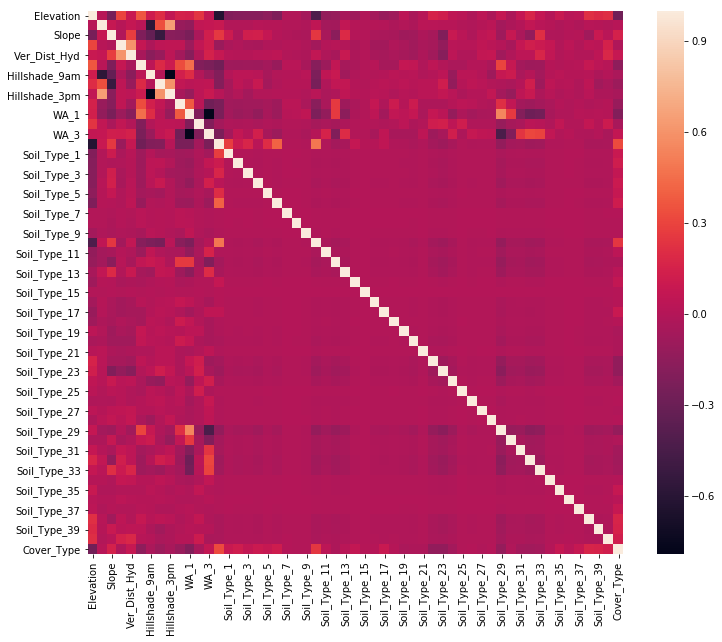

In [12]:
# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df.corr());

It looks like +/-0.6 is about the strongest correlation among any two variables. If it were 0.8, I would be worried about multicollinearity, but I don't think 0.6 poses a real problem. At any rate, the Principal Components Analysis I'll do later will remove any multicollinearity.

I suspect that not all of these features are useful for prediction (especially all those soil types). To test this, I will run a quick Random Forest model and look at the feature importances. If a number of features seem really unimportant for prediction, I can combine/eliminate them using Principal Components Analysis.

In [13]:
# Get a random sample of observations for testing
quick_sample = df.sample(10000, random_state=1)
quick_sample_y = quick_sample['Cover_Type']
quick_sample_x = quick_sample.drop('Cover_Type', axis=1)

# Create and fit a Random Forest classifier to the quick sample data
trial_forest = RandomForestClassifier()
trial_forest.fit(quick_sample_x, quick_sample_y)

/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

0.9903


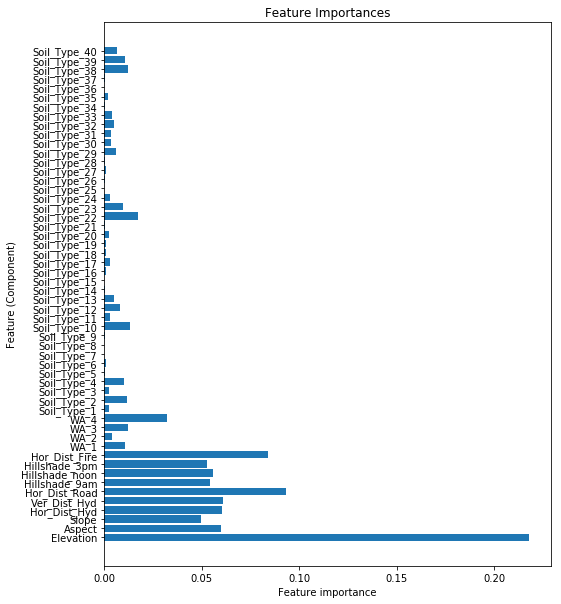

In [14]:
# Visualize the feature importances from the Random Forest trial
print(trial_forest.score(quick_sample_x, quick_sample_y))
n_features = quick_sample_x.shape[1]
plt.figure(figsize=(8,10))
plt.barh(range(n_features), trial_forest.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), quick_sample_x.columns) 
plt.xlabel("Feature importance")
plt.ylabel("Feature (Component)")
plt.title('Feature Importances');

Judging by this quick-and-dirty analysis, there may be about 14 features (all of them soil types) that have little importance for prediction. Rather than identify and eliminate them manually, I will use Principal Components Analysis (below) to reduce the dimensions of the dataset to 40.

# Preprocessing

In this section I manipulate the data to prepare it for modeling.

## Train-validation-test split

First up is the train-test split. Note that I am actually making two splits. First, I take 80% of the total dataset to use as my training data. Then I take the remaining 20% of the original dataset and devote half of that to validation and half to be used as a true holdout set, which I will only use to evaluate the final versions of each of my models.

Note also that I am doing stratified splits so that each subset will contain all the classes in the same proportions as in the original dataset.

In [36]:
# Split first into training and test datasets
y = df['Cover_Type']
X = df.drop('Cover_Type', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)

In [37]:
# Split again into validation and true holdout (test) datasets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,
                                                random_state=1,
                                                stratify=y_test)

In [38]:
# Examine shapes of the subsets
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(464809, 54) (464809,)
(58101, 54) (58101,)
(58102, 54) (58102,)


I know that later I will want to compare model performance on the raw data and the preprocessed version, so at this point (before preprocessing) I will save copies for later.

In [39]:
# Save raw copies of train and validation sets before further preprocessing
X_train_raw = X_train.copy()
y_train_raw = y_train.copy()

X_val_raw = X_val.copy()
y_val_raw = y_val.copy()

## Resampling

My next preprocessing step is to deal with the class imbalance. My overall strategy is to undersample the bigger classes and oversample the smaller ones so that every class is the same size as the median-sized class.

First, I'll put the training data back into one DataFrame to make things a little easier.

In [40]:
# Concatenate X_train and y_train for resampling
df_train = pd.concat([X_train, y_train], axis=1)
print(len(df_train))
df_train.head()

464809


,Elevation,Aspect,Slope,Hor_Dist_Hyd,Ver_Dist_Hyd,Hor_Dist_Road,Hillshade_9am,Hillshade_noon,Hillshade_3pm,Hor_Dist_Fire,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
450015,3250,35,4,534,212,2969,219,231,148,3161,...,0,0,0,0,0,0,0,0,0,1
127010,2580,61,20,30,-1,1061,232,193,85,553,...,0,0,0,0,0,0,0,0,0,1
247694,2216,41,38,384,251,424,194,129,40,295,...,0,0,0,0,0,0,0,0,0,3
548749,3166,181,17,242,61,3252,224,248,152,630,...,0,0,1,0,0,0,0,0,0,2
29431,2900,296,25,210,92,5076,142,223,218,4763,...,0,0,0,0,0,0,0,0,0,1


Next, let's review the current counts of all the classes.

In [41]:
# Check for class imbalance
df_train.Cover_Type.value_counts()

2    226640
1    169472
3     28603
7     16408
6     13894
5      7594
4      2198
Name: Cover_Type, dtype: int64

Now I can use `RandomUnderSampler` and `SMOTE` to undersample the larger classes and oversample the smaller ones, aiming for every class to have 16,408 observations.

In [42]:
# Randomly undersample the larger classes
rus = RandomUnderSampler(random_state=3, 
                         sampling_strategy={1:16408, 2:16408, 3:16408,})


X_rus, y_rus = rus.fit_resample(X_train, y_train)

# Check class counts
Counter(y_rus)

Counter({1: 16408, 2: 16408, 3: 16408, 4: 2198, 5: 7594, 6: 13894, 7: 16408})

In [44]:
# Randomly oversample the smaller classes
smote = SMOTE(random_state=3, sampling_strategy={4:16408, 5:16408, 6:16408})

X_resampled, y_resampled = smote.fit_resample(X_rus, y_rus)

# Check class counts
Counter(y_resampled)

Counter({1: 16408, 2: 16408, 3: 16408, 4: 16408, 5: 16408, 6: 16408, 7: 16408})

The final count above shows that the classes are now balanced.

## Scaling

The next transformation I want to do is to standardize the features. This isn't required for Random Forests, but it is helpful for more complex algorithms like Support Vector Machines (plus it doesn't hurt Random Forests, so I may as well do it now).

In [45]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)
X_scaled = pd.DataFrame(X_scaled)

/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [46]:
# Check the results
X_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
count,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,...,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05,1.148560e+05
mean,2.133063e-16,-3.402508e-18,1.299140e-17,-1.899218e-17,-2.822535e-17,5.765705e-17,3.554693e-16,-5.596817e-16,2.417637e-16,-3.315899e-17,...,-4.008774e-17,5.416175e-17,3.552528e-17,1.082616e-19,-3.181345e-17,-8.966383e-18,2.056971e-17,7.497891e-17,-4.751139e-17,3.136494e-17
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,...,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-2.120858e+00,-1.423987e+00,-1.962208e+00,-1.090620e+00,-3.324786e+00,-1.287201e+00,-6.938578e+00,-7.290815e+00,-2.908838e+00,-1.375326e+00,...,-1.454026e-01,-2.144755e-01,-2.075198e-01,-4.113307e-02,-8.485013e-02,-2.107680e-02,-4.489173e-02,-2.248845e-01,-2.157161e-01,-1.715900e-01
25%,-8.945149e-01,-8.318577e-01,-7.743657e-01,-7.708600e-01,-7.533096e-01,-7.230251e-01,-5.451907e-01,-5.145001e-01,-6.167281e-01,-7.093079e-01,...,-1.454026e-01,-2.144755e-01,-2.075198e-01,-4.113307e-02,-8.485013e-02,-2.107680e-02,-4.489173e-02,-2.248845e-01,-2.157161e-01,-1.715900e-01
50%,1.014521e-02,-2.852769e-01,-1.804444e-01,-2.315627e-01,-3.110812e-01,-3.030859e-01,2.376729e-01,1.455306e-01,7.522952e-02,-2.251362e-01,...,-1.454026e-01,-2.144755e-01,-2.075198e-01,-4.113307e-02,-8.485013e-02,-2.107680e-02,-4.489173e-02,-2.248845e-01,-2.157161e-01,-1.715900e-01
75%,8.544149e-01,9.354203e-01,6.510454e-01,4.843186e-01,4.587237e-01,4.271125e-01,7.595821e-01,7.175571e-01,7.023161e-01,4.305037e-01,...,-1.454026e-01,-2.144755e-01,-2.075198e-01,-4.113307e-02,-8.485013e-02,-2.107680e-02,-4.489173e-02,-2.248845e-01,-2.157161e-01,-1.715900e-01
max,2.655364e+00,1.855498e+00,5.283631e+00,5.509806e+00,8.975714e+00,4.036787e+00,1.346730e+00,1.553596e+00,2.561952e+00,4.988848e+00,...,6.877457e+00,4.662538e+00,4.818818e+00,2.431134e+01,1.178549e+01,4.744553e+01,2.227582e+01,4.446727e+00,4.635722e+00,5.827845e+00


The features have now been standardized so that they all have a mean of 0 and a standard deviation of 1.

Let's just get a quick visual confirmation of this change with some histograms.

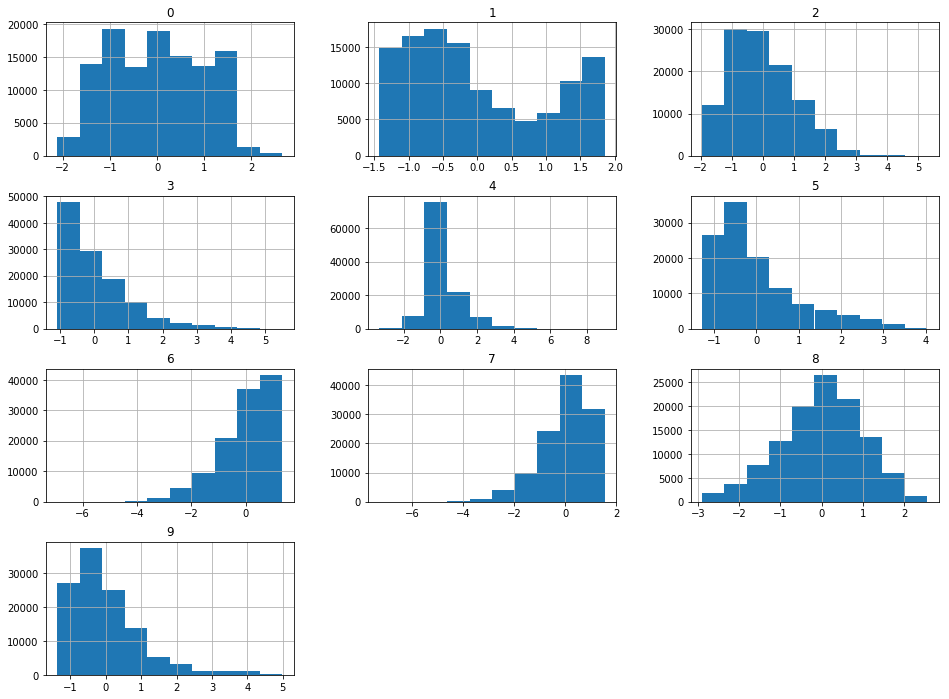

In [48]:
# Visualize the distributions again
X_scaled.loc[:,:9].hist(figsize=(16, 12));

Now that the training data has been scaled, I can move on to PCA.

## PCA

Principal Components Analysis takes the features we have and tries to combine them in ways that maximize the amount of variance the components can explain in the data. For datasets like the one I'm working with here, where there are lots of features, PCA can help us avoid the negative effects of having numerous features while still allowing us to account for as much variance as possible. For my analysis below, I aim to find a number of components that will explain at least 80% of the variance in the data.

First, let's see how much variance we can explain with a wide range of components. If any of these look promising, we can drill down further.

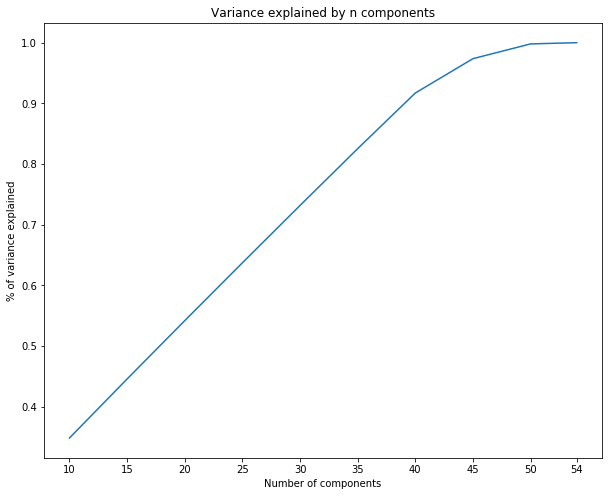

In [49]:
# Try several numbers of components to explain 80% of variance
comps = [10, 15, 20, 25, 30, 35, 40, 45, 50, 54]
var_sums = []
for comp in comps:
    pca = PCA(n_components=comp)
    pca.fit_transform(X_scaled)
    var_sums.append(np.sum(pca.explained_variance_ratio_))
    
# Visualize results
plt.figure(figsize=(10,8))
plt.plot(comps, var_sums)
plt.xlabel('Number of components')
plt.ylabel('% of variance explained')
plt.title('Variance explained by n components')
plt.xticks([10, 15, 20, 25, 30, 35, 40, 45, 50, 54])
plt.show();

Forty components seem to capture about 90% of the variance in the data, which aligns with what we expected based on the feature importances plot above.

In [50]:
# View the % variance explained for each number of components
display(list(zip(comps, var_sums)))

[(10, 0.34824014116486507),
 (15, 0.445556521096915),
 (20, 0.5417261286459644),
 (25, 0.6370695639008744),
 (30, 0.7316361089412456),
 (35, 0.8252774059371302),
 (40, 0.9170275152039136),
 (45, 0.9736568637688149),
 (50, 0.9979901475164933),
 (54, 1.0)]

From the plot and the list above, it's clear that we could explain over 90% of the variance in the data with 40 components (out of a possible 54). Using fewer features/components will help us avoid overfitting on the training data, but at the expense of a little bit of accuracy. I think it's a worthwhile trade.

## Preprocessing pipeline

I know that I want to transform my data so that it is standardized and has 40 components. I will use a pipeline to do this so that I can easily transform my validation and test sets in the same way as my training set without leaking data from one set to another.

In [51]:
# Build a pipeline for the preprocessing steps
pipe_prepro = Pipeline([('scaler', StandardScaler()),
                        ('pca', PCA(n_components=40))])

I will fit the preprocessing pipeline to the training data (which has been resampled), then use the pipeline to transform the validation and test sets separately.

In [56]:
# Fit the pipeline and transform the training dataset
X_train_trans = pipe_prepro.fit_transform(X_resampled)

/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [57]:
# Use the pipeline to transform the validation and test datasets
X_val_trans = pipe_prepro.transform(X_val)
X_test_trans = pipe_prepro.transform(X_test)

/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


This transformation will form part of the final pipeline, but by transforming the data now, I can more easily use it to build and evaluate my models.

In [60]:
y_train_res = y_resampled.copy()

# Testing various algorithms

## Random Forest 1

This is a Random Forest with no class balancing, standardization, or PCA.

### Baseline model

In [13]:
# Fit and score a baseline RandomForestClassifier
forest1 = RandomForestClassifier()
forest1.fit(X_train_raw, y_train_raw)

train_pred = forest1.predict(X_train_raw)

print_metrics(y_train_raw, train_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.997835670135475
-------
Confusion matrix:
[[169282    178      0      0      2      0     10]
 [   424 226194     12      0      3      6      1]
 [     0     33  28558      3      2      7      0]
 [     0      0     16   2180      0      2      0]
 [     4    111      8      0   7470      1      0]
 [     1     22     78      7      0  13786      0]
 [    70      5      0      0      0      0  16333]]
-------
Classification report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00    169472
           2       1.00      1.00      1.00    226640
           3       1.00      1.00      1.00     28603
           4       1.00      0.99      0.99      2198
           5       1.00      0.98      0.99      7594
           6       1.00      0.99      1.00     13894
           7       1.00      1.00      1.00     16408

    accuracy                           1.00    464809
   macro avg       1.00      0.99      1.00    464809
weighted

In [14]:
# Validate
val_pred = forest1.predict(X_val_raw)

print_metrics(y_val_raw, val_pred)

Accuracy: 0.944940706700401
-------
Confusion matrix:
[[20130  1003     0     0    10     4    37]
 [ 1112 27071    55     2    45    36     9]
 [    0    84  3408     9     3    71     0]
 [    0     0    50   220     0     5     0]
 [   24   224    18     0   677     7     0]
 [    3    56   184     7     3  1483     0]
 [  127    10     0     0     1     0  1913]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.94      0.95      0.95     21184
           2       0.95      0.96      0.95     28330
           3       0.92      0.95      0.93      3575
           4       0.92      0.80      0.86       275
           5       0.92      0.71      0.80       950
           6       0.92      0.85      0.89      1736
           7       0.98      0.93      0.95      2051

    accuracy                           0.94     58101
   macro avg       0.94      0.88      0.91     58101
weighted avg       0.94      0.94      0.94     58101



### Tune parameters with GridSearchCV

In [15]:
# Use GridSearchCV to find best parameters for the Random Forest
params = {'n_estimators': [50, 100],
          'max_features': [30, 40, 54],
          'max_depth': [20, 25]}

grid_forest1 = GridSearchCV(forest1, params, cv=3, n_jobs=-1)

grid_forest1.fit(X_train_raw, y_train_raw)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='wa

In [16]:
# View best score and parameters
print('Best score:', grid_forest1.best_score_)
print('Best params:', grid_forest1.best_params_)

Best score: 0.9559324367643484
Best params: {'max_depth': 25, 'max_features': 40, 'n_estimators': 100}


In [17]:
# View training metrics for the best model
y_pred = grid_forest1.predict(X_train_raw)
print_metrics(y_train_raw, y_pred)

Accuracy: 0.9933822279689076
-------
Confusion matrix:
[[167643   1824      0      0      5      0      0]
 [   179 226449      0      0      9      3      0]
 [     0    123  28480      0      0      0      0]
 [     0      0      0   2197      0      1      0]
 [     2    734      1      0   6857      0      0]
 [     0     86      0      0      0  13808      0]
 [   104      5      0      0      0      0  16299]]
-------
Classification report:
              precision    recall  f1-score   support

           1       1.00      0.99      0.99    169472
           2       0.99      1.00      0.99    226640
           3       1.00      1.00      1.00     28603
           4       1.00      1.00      1.00      2198
           5       1.00      0.90      0.95      7594
           6       1.00      0.99      1.00     13894
           7       1.00      0.99      1.00     16408

    accuracy                           0.99    464809
   macro avg       1.00      0.98      0.99    464809
weighte

In [18]:
# View validation metrics for the best model
y_pred = grid_forest1.predict(X_val_raw)
print_metrics(y_val_raw, y_pred)

Accuracy: 0.9639076780089844
-------
Confusion matrix:
[[20247   894     0     0     4     0    39]
 [  456 27758    32     0    43    33     8]
 [    0    57  3453    11     3    51     0]
 [    0     0    32   238     0     5     0]
 [    9   200    14     0   723     4     0]
 [    2    36    78     4     2  1614     0]
 [   73     6     0     0     1     0  1971]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.97      0.96      0.96     21184
           2       0.96      0.98      0.97     28330
           3       0.96      0.97      0.96      3575
           4       0.94      0.87      0.90       275
           5       0.93      0.76      0.84       950
           6       0.95      0.93      0.94      1736
           7       0.98      0.96      0.97      2051

    accuracy                           0.96     58101
   macro avg       0.95      0.92      0.93     58101
weighted avg       0.96      0.96      0.96     58101



## Random Forest 2

This is a Random Forest using the training set that has been resampled, standardized, and transformed with PCA.

### Baseline model

In [0]:
# Fit and score a baseline RandomForestClassifier
forest2 = RandomForestClassifier()
forest2.fit(X_train_trans, y_train_res)

y_pred = forest2.predict(X_train_trans)

print_metrics(y_train_res, y_pred)

/Users/jennykreiger/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.9964738455109006
-------
Confusion matrix:
[[16341    40     1     0     5     2    19]
 [  106 16262    13     0    16    10     1]
 [    0     4 16360    10     2    32     0]
 [    0     0     4 16403     0     1     0]
 [    3    16     7     0 16378     4     0]
 [    1     6    42    31     7 16321     0]
 [   18     4     0     0     0     0 16386]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.99      1.00      0.99     16408
           2       1.00      0.99      0.99     16408
           3       1.00      1.00      1.00     16408
           4       1.00      1.00      1.00     16408
           5       1.00      1.00      1.00     16408
           6       1.00      0.99      1.00     16408
           7       1.00      1.00      1.00     16408

   micro avg       1.00      1.00      1.00    114856
   macro avg       1.00      1.00      1.00    114856
weighted avg       1.00      1.00      1.00    114856



In [0]:
# Validate 
y_pred = forest2.predict(X_val_trans)
print_metrics(y_val, y_pred)

Accuracy: 0.17373194953615256
-------
Confusion matrix:
[[ 3801  3115   660   306     3   491 12808]
 [ 4524  5046  1890   543     0   636 15691]
 [  965  1427    74    16     0   130   963]
 [  104    54     6     0     0     2   109]
 [  135   188    41    22     0    26   538]
 [  566   479    41     1     0    49   600]
 [  475   264    29    98     0    61  1124]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.36      0.18      0.24     21184
           2       0.48      0.18      0.26     28330
           3       0.03      0.02      0.02      3575
           4       0.00      0.00      0.00       275
           5       0.00      0.00      0.00       950
           6       0.04      0.03      0.03      1736
           7       0.04      0.55      0.07      2051

   micro avg       0.17      0.17      0.17     58101
   macro avg       0.13      0.14      0.09     58101
weighted avg       0.37      0.17      0.22     58101



The Random Forest scored over 99% accuracy on the training set, but only 17% on the validation set! The Random Forest is clearly overfit to the training data. Below I'll use a grid search to see if there are other parameters that would help the Random Forest perform better on the validation set.

For now, let's take a look at the importance the Random Forest assigned to each of the 40 components.

In [0]:
# Check the feature importances
forest2.feature_importances_

array([0.06553765, 0.01673424, 0.02214505, 0.01898937, 0.02673212,
       0.01659235, 0.04410163, 0.01531569, 0.03025534, 0.02743305,
       0.02303043, 0.02119864, 0.02616872, 0.01857692, 0.02535643,
       0.02113854, 0.01760921, 0.0492609 , 0.02909827, 0.02845564,
       0.02705693, 0.02015766, 0.03466314, 0.02182325, 0.02061755,
       0.0417118 , 0.01587844, 0.02096205, 0.02142449, 0.01304749,
       0.02004607, 0.0152457 , 0.02569983, 0.02490222, 0.02729378,
       0.02161401, 0.04266143, 0.01645338, 0.01482689, 0.01018369])

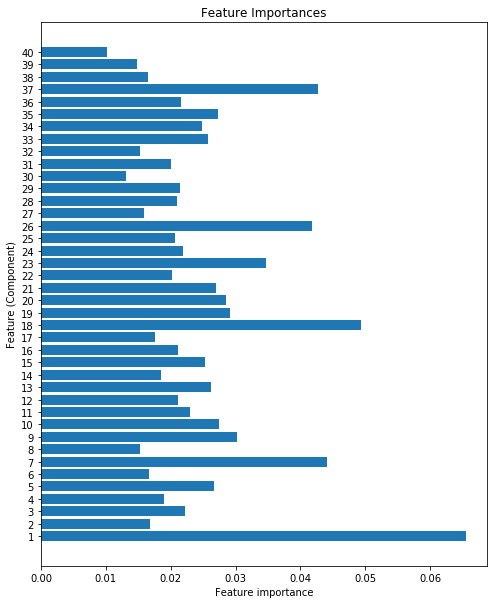

In [0]:
# Visualize feature importances
plot_feature_importances(forest2)

The plot above shows that there are a few features that are a bit more powerful than the rest. A grid search (below) will help me determine if a different maximum depth of tree or a different number of trees would improve performance.

### Tune parameters with GridSearchCV

In [0]:
# Use GridSearchCV to find best parameters for the Random Forest
params = {'n_estimators': [100],
          'max_features': [5, 20, 40],
          'max_depth': [20, 25],
          'min_samples_leaf': [5, 10, 20]}

grid_forest2 = GridSearchCV(forest2, params, cv=3, n_jobs=-1)

grid_forest2.fit(X_train_trans, y_train_res)

KeyboardInterrupt: 

In [0]:
# View best score and parameters
print('Best score:', grid_forest2.best_score_)
print('Best params:', grid_forest2.best_params_)

Best score: 0.884124468900188
Best params: {'max_depth': 20, 'n_estimators': 100}


In [0]:
# View the metrics for the best model
y_pred = grid_forest2.predict(X_train_trans)
print_metrics(y_train_res, y_pred)

Training accuracy: 0.983918994218848
-------
Confusion matrix:
[[16048   167     2     0   122     4    65]
 [  235 15746    38     0   281   102     6]
 [    0     2 15812   153    40   401     0]
 [    0     0     1 16400     0     7     0]
 [    1     7    26     0 16368     6     0]
 [    0     3    46    81    20 16258     0]
 [   28     1     0     0     2     0 16377]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.98      0.98      0.98     16408
           2       0.99      0.96      0.97     16408
           3       0.99      0.96      0.98     16408
           4       0.99      1.00      0.99     16408
           5       0.97      1.00      0.98     16408
           6       0.97      0.99      0.98     16408
           7       1.00      1.00      1.00     16408

    accuracy                           0.98    114856
   macro avg       0.98      0.98      0.98    114856
weighted avg       0.98      0.98      0.98    1

In [0]:
# View the metrics for the best model
y_pred = grid_forest2.predict(X_val_trans)
print_metrics(y_val, y_pred)

0.2972582227500387

## Evaluating the best Random Forest classifier

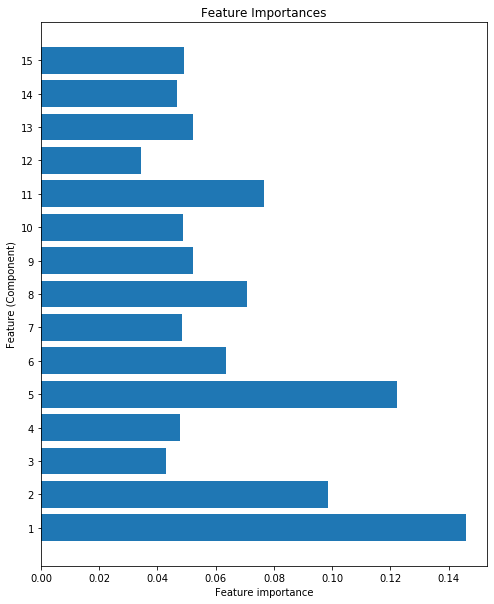

In [0]:
# Review feature importances for the model with the best parameters
forest_best = RandomForestClassifier(max_depth=20, n_estimators=100)
forest_best.fit(X_train_trans, y_train_res)

plot_feature_importances(forest_best)

In [0]:
# View metrics for the optimized model
y_pred = forest_best.predict(X_train_trans)
print_metrics(y_train_res, y_pred)

Training accuracy: 0.9837100369157902
-------
Confusion matrix:
[[16043   161     1     0   125     3    75]
 [  165 15792    43     0   301   100     7]
 [    0     5 15784   144    42   433     0]
 [    0     0     1 16396     0    11     0]
 [    1    10    30     0 16360     7     0]
 [    0     7    52   101    19 16229     0]
 [   24     1     0     0     2     0 16381]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.99      0.98      0.98     16408
           2       0.99      0.96      0.98     16408
           3       0.99      0.96      0.98     16408
           4       0.99      1.00      0.99     16408
           5       0.97      1.00      0.98     16408
           6       0.97      0.99      0.98     16408
           7       1.00      1.00      1.00     16408

    accuracy                           0.98    114856
   macro avg       0.98      0.98      0.98    114856
weighted avg       0.98      0.98      0.98    

In [0]:
# View the metrics for the best model
y_pred = forest_best.predict(X_val_trans)
print_metrics(y_val, y_pred)

0.31147484552761573

In [0]:
# View full metrics for the validation set
y_val_pred = forest_best.predict(X_val_trans)
print_metrics(y_val, y_val_pred)

Training accuracy: 0.31147484552761573
-------
Confusion matrix:
[[17838     0     0     0     0     0  3346]
 [23105     0     0     0     0     0  5225]
 [ 1706     0     0     0     0     0  1869]
 [  199     0     0     0     0     0    76]
 [  598     0     0     0     0     0   352]
 [  934     0     0     0     0     0   802]
 [ 1792     0     0     0     0     0   259]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.39      0.84      0.53     21184
           2       0.00      0.00      0.00     28330
           3       0.00      0.00      0.00      3575
           4       0.00      0.00      0.00       275
           5       0.00      0.00      0.00       950
           6       0.00      0.00      0.00      1736
           7       0.02      0.13      0.04      2051

    accuracy                           0.31     58101
   macro avg       0.06      0.14      0.08     58101
weighted avg       0.14      0.31      0.19   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
# Find AUC and plot ROC curve
# y_score_forest = forest_best.fit(X_train_trans, y_train_res).decision_function(X_test_trans)

roc_it(y_test, y_score_forest)

## XGBoost

intro

### Baseline model

In [0]:
xg = xgb.XGBClassifier()

In [0]:
xg.fit(X_train_trans, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
y_pred = xg.predict(X_train_trans)

print_metrics(y_train_res, y_pred)

Training accuracy: 0.7035331197325346
-------
Confusion matrix:
[[10286  2744    26     0  1060   128  2164]
 [ 4276  7305   326    10  3313   937   241]
 [    0    21 10899  1819   690  2979     0]
 [    0     0   811 15210     0   387     0]
 [  610  1489   694     0 12976   639     0]
 [   22   101  3841  1626   826  9992     0]
 [ 2146    45     0     0    80     0 14137]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.59      0.63      0.61     16408
           2       0.62      0.45      0.52     16408
           3       0.66      0.66      0.66     16408
           4       0.81      0.93      0.87     16408
           5       0.68      0.79      0.73     16408
           6       0.66      0.61      0.64     16408
           7       0.85      0.86      0.86     16408

    accuracy                           0.70    114856
   macro avg       0.70      0.70      0.70    114856
weighted avg       0.70      0.70      0.70    

In [0]:
y_pred = xg.predict(X_val_trans)

print_metrics(y_val, y_pred)

0.03530059723584792

### Tune parameters with GridSearchCV

In [0]:
params = {'learning_rate': [0.01, 0.1],
          'n_estimators': [5, 30, 100]
}

grid_xgb = GridSearchCV(xg, params, scoring='accuracy', cv=3, n_jobs=-1)
grid_xgb.fit(X_train_trans, y_train_res)

print('Best score:', grid_xgb.best_score_)
print('Best params:', grid_xgb.best_params_)

Best score: 0.6970206171205684
Best params: {'learning_rate': 0.1, 'n_estimators': 100}


In [0]:
y_pred = grid_xgb.predict(X_train_trans)

print_metrics(y_train_res, y_pred)

In [0]:
y_pred = grid_xgb.predict(X_val_trans)

print_metrics(y_val, y_pred)

0.03530059723584792

## Evaluating the best XGBoost classifier

In [0]:
# Build the optimized model
# xgb_best = XGBClassifier() # insert best params
# xgb_best.fit(X_train_trans, y_train_res)

In [0]:
# View metrics for the optimized model
# y_pred = xgb_best.predict(X_train_trans)
# print_metrics(y_train_res, y_pred)

In [0]:
# Score the model on the validation set
# xgb_best.score(X_val_trans, y_val)

In [0]:
# View full metrics for the validation set
# y_val_pred = xgb_best.predict(X_val_trans)
# print_metrics(y_val, y_val_pred)

In [0]:
# Find AUC and plot ROC curve
# y_score_xg = xgb_best.fit(X_train_trans, y_train_res).decision_function(X_test_trans)

# roc_it(y_test, y_score_xg)

## Support Vector Machine

### Baseline model

In [0]:
# Build a baseline model
svc = SVC(gamma='auto')
svc.fit(X_train_trans, y_train_res)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
y_pred = svc.predict(X_train_trans)
print_metrics(y_train_res, y_pred)

Training accuracy: 0.6426830117712614
-------
Confusion matrix:
[[ 8493  4939    12     0  1103    91  1770]
 [ 3204  9045   328    18  2973   766    74]
 [    0   108  8891  2699   601  4109     0]
 [    0     0  1548 14003     0   857     0]
 [  587  2880  1363     0 11024   554     0]
 [    1   337  3484  2050  1075  9461     0]
 [ 2714   680    63     0    52     0 12899]]
-------
Classification report:
              precision    recall  f1-score   support

           1       0.57      0.52      0.54     16408
           2       0.50      0.55      0.53     16408
           3       0.57      0.54      0.55     16408
           4       0.75      0.85      0.80     16408
           5       0.66      0.67      0.66     16408
           6       0.60      0.58      0.59     16408
           7       0.87      0.79      0.83     16408

    accuracy                           0.64    114856
   macro avg       0.64      0.64      0.64    114856
weighted avg       0.64      0.64      0.64    

In [0]:
svc.score(X_val_trans, y_val)

0.061530782602709076

### Tune parameters with GridSearchCV

In [ ]:
params = {'gamma': [0.1, 1.0, 100.0],
          'C': [0.1, 1.0, 10.0]}

grid_svc = GridSearchCV(svc, params, cv=3, scoring='accuracy')
grid_svc.fit(X_train_trans, y_train_res)

In [0]:
print('Best score:', grid_svc.best_score_)
print('Best params:', grid_svc.best_params_)

KeyboardInterrupt: 

In [0]:
y_pred = grid_svc.predict(X_train_trans)
print_metrics(y_train_res, y_pred)

In [0]:
y_pred = grid_svc.predict(X_val_trans)
print_metrics(y_val, y_pred)

### Evaluating the best Support Vector classifier

In [0]:
# Build the optimized model
# svc_best = SVC() # insert best params
# svc_best.fit(X_train_trans, y_train_res)

In [0]:
# View metrics for the optimized model
# y_pred = svc_best.predict(X_train_trans)
# print_metrics(y_train_res, y_pred)

In [0]:
# Score the model on the validation set
# svc_best.score(X_val_trans, y_val)

In [0]:
# View full metrics for the validation set
# y_val_pred = svc_best.predict(X_val_trans)
# print_metrics(y_val, y_val_pred)

In [0]:
# Find AUC and plot ROC curve
# y_score_svc = svc_best.fit(X_train_trans, y_train_res).decision_function(X_test_trans)

# roc_it(y_test, y_score_xg)

# Pipeline

In [0]:
pipe = Pipeline([('scaler', StandardScaler),
                 ('pca', PCA(n_components=40)),
                ])



# Interpretations and recommendations

# To cut

### Save copy of the training set

In [0]:
# Save the clean dataset for easier access later
y_train = pd.DataFrame(y_smote, columns=['Cover_Type'])
X_train = pd.DataFrame(X_train_pca)
sample_to_save = pd.concat([X_train, y_train], axis=1)
sample_to_save.to_csv('trees_train.csv')

In [0]:
raw_to_save = pd.concat([X_train_raw, y_train_raw], axis=1)
raw_to_save.to_csv('trees_train_raw.csv')

### Save a copy of the validation set

In [0]:
y_val = pd.DataFrame(y_val, columns=['Cover_Type'])
y_val.reset_index(inplace=True)
y_val.drop('index', axis=1, inplace=True)

In [0]:
X_val = pd.DataFrame(X_val_pca)

In [0]:
val_to_save = pd.concat([X_val, y_val], axis=1, ignore_index=True)
len(val_to_save)

58101

In [0]:
val_to_save.to_csv('trees_val.csv')

In [0]:
val_raw_to_save = pd.concat([X_val_raw, y_val_raw], axis=1)
val_raw_to_save.to_csv('trees_val_raw.csv')

### Reconstitute training and validation sets

In [7]:
train_trans = pd.read_csv('/content/drive/My Drive/fs-project-4/trees_train.csv')
train_trans.drop('Unnamed: 0', axis=1, inplace=True)
train_trans.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,Cover_Type
0,-1.919642,1.545429,-2.154026,0.465190,-0.039087,-0.898641,-0.726181,-0.518156,-0.795170,1.832770,-0.138805,0.128179,0.312822,0.642169,-0.338050,0.345284,-0.143583,-0.230057,0.398625,0.214304,-0.206256,0.246812,0.127521,0.001343,0.139274,-0.053826,-0.072864,0.038964,0.130061,-0.094863,-0.073763,-0.016226,-0.025170,0.043097,-0.013932,-0.002199,-0.036792,0.000732,0.005547,0.380143,1
1,-0.729440,2.842710,-0.805643,0.700709,-0.368983,-0.577724,-0.114275,-0.166068,-0.601834,1.773628,-0.094106,0.195288,0.346119,0.715567,-0.401542,0.401931,-0.058230,-0.296643,0.449127,0.308890,-0.197934,0.328951,0.198096,0.073676,0.192417,-0.052386,-0.060271,0.037031,0.156051,-0.132952,-0.051246,-0.017335,-0.008949,0.047760,0.002531,-0.007379,-0.044616,-0.000500,0.006419,0.723786,1
2,-1.414295,0.465655,-0.421006,-1.710639,-0.866943,1.473237,-0.564235,-0.119146,-0.177979,0.144611,-0.351753,-1.359997,-2.321331,-1.576757,-0.653744,0.731353,0.039865,-1.274285,-0.129857,-0.005465,0.443443,-0.142586,0.285028,0.579230,-0.012948,-0.130535,0.106990,-0.034389,-0.203800,-0.162897,-0.034065,-0.040310,-0.122626,-0.078465,-0.025126,-0.004162,-0.032245,0.003648,0.005026,0.723705,1
3,-1.719740,0.537204,-1.976603,2.532597,-0.914213,-0.833309,-0.546785,-0.474177,0.074945,1.508607,-0.116700,0.031932,0.328077,0.738780,-0.271144,0.298669,-0.077510,-0.320026,0.450990,0.371441,-0.073971,0.401843,0.156568,-0.052216,0.093633,0.000771,-0.051709,0.070042,0.123255,-0.108564,-0.093112,0.012405,-0.039666,0.069022,-0.000290,-0.012513,-0.033794,-0.004891,0.000309,-0.194112,1
4,-1.661729,-0.161570,0.811565,-2.110810,-0.110697,-0.049399,0.393778,1.151023,-0.598367,0.079608,0.876281,-0.290931,-2.049247,3.027078,0.037458,-1.519455,0.907814,-0.314155,0.416904,-0.099493,-0.086155,-0.068519,-0.265700,0.240311,0.029959,-0.126690,-0.378482,-0.051779,-0.116483,0.001089,-0.078067,0.048836,-0.085332,-0.066123,-0.053483,-0.013638,0.028344,-0.002567,-0.006874,0.288379,1


In [8]:
train_raw = pd.read_csv('/content/drive/My Drive/fs-project-4/trees_train_raw.csv')
train_raw.drop('Unnamed: 0', axis=1, inplace=True)
train_raw.head()

,Elevation,Aspect,Slope,Hor_Dist_Hyd,Ver_Dist_Hyd,Hor_Dist_Road,Hillshade_9am,Hillshade_noon,Hillshade_3pm,Hor_Dist_Fire,WA_1,WA_2,WA_3,WA_4,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,Soil_Type_5,Soil_Type_6,Soil_Type_7,Soil_Type_8,Soil_Type_9,Soil_Type_10,Soil_Type_11,Soil_Type_12,Soil_Type_13,Soil_Type_14,Soil_Type_15,Soil_Type_16,Soil_Type_17,Soil_Type_18,Soil_Type_19,Soil_Type_20,Soil_Type_21,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_25,Soil_Type_26,Soil_Type_27,Soil_Type_28,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
0,3250,35,4,534,212,2969,219,231,148,3161,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,2580,61,20,30,-1,1061,232,193,85,553,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2216,41,38,384,251,424,194,129,40,295,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
3,3166,181,17,242,61,3252,224,248,152,630,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2
4,2900,296,25,210,92,5076,142,223,218,4763,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
val_trans = pd.read_csv('/content/drive/My Drive/fs-project-4/trees_val.csv')
val_trans.drop('Unnamed: 0', axis=1, inplace=True)
val_trans.rename(columns={'40':'Cover_Type'}, inplace=True)

In [0]:
val_raw = pd.read_csv('/content/drive/My Drive/fs-project-4/trees_val_raw.csv')
val_raw.drop('Unnamed: 0', axis=1, inplace=True)

In [11]:
y_train = train_trans['Cover_Type']
X_train = train_trans.drop('Cover_Type', axis=1)

y_train_raw = train_raw['Cover_Type']
X_train_raw = train_raw.drop('Cover_Type', axis=1)

y_val = val_trans['Cover_Type']
X_val = val_trans.drop('Cover_Type', axis=1)

y_val_raw = val_raw['Cover_Type']
X_val_raw = val_raw.drop('Cover_Type', axis=1)

print('Transformed train & val datasets')
print('Train shape:', X_train.shape, y_train.shape)
print('Val shape:', X_val.shape, y_val.shape)
print('\n')
print('Raw train and val datasets')
print('Train shape:', X_train_raw.shape, y_train_raw.shape)
print('Val shape:', X_val_raw.shape, y_val_raw.shape)

Transformed train & val datasets
Train shape: (114856, 40) (114856,)
Val shape: (58101, 40) (58101,)


Raw train and val datasets
Train shape: (464809, 54) (464809,)
Val shape: (58101, 54) (58101,)
